<a href="https://colab.research.google.com/github/ilham-mukti/Mencoba-Neural-Network/blob/main/Data_Engineering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install jcopdl

  Created wheel for jcopdl: filename=jcopdl-1.1.9-py2.py3-none-any.whl size=16925 sha256=e1cf0c53153f12d7c2d0d1c48af975601d5252517805cb29a9991c7706e88dac
  Stored in directory: /root/.cache/pip/wheels/bb/fd/9d/fc72bcf569000eabd487e654fdf55b587e66882b60eaa5693b
Successfully built jcopdl


In [198]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.models import mobilenet_v2
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision.utils import make_grid

from tqdm.auto import tqdm
from jcopdl.callback import Callback, set_config
from jcopdl.layers import linear_block, conv_block

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import PIL
from PIL import Image

import pandas as pd
import numpy as np
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [6]:
!cp /content/kaggle.json /root/.kaggle/kaggle.json

In [7]:
!kaggle datasets download -d dionisiusdh/indonesian-batik-motifs

 93% 244M/262M [00:03<00:00, 53.7MB/s]
100% 262M/262M [00:03<00:00, 84.0MB/s]


In [ ]:
!unzip /content/Batik/indonesian-batik-motifs.zip -d /content/Batik/

In [202]:
images, labels = [], []
import os
for dirname, _, filenames in os.walk('/content/Batik/'):
  for filename in filenames:
    images.append(os.path.join(dirname, filename).split('/')[-1]) # /folder/blabla/xxx.jpg
    labels.append(os.path.join(dirname, filename).split('/')[-2])

In [203]:
label2cat = np.unique(labels)
label2cat

array(['batik-bali', 'batik-betawi', 'batik-celup', 'batik-cendrawasih',
       'batik-ceplok', 'batik-ciamis', 'batik-garutan', 'batik-gentongan',
       'batik-kawung', 'batik-keraton', 'batik-lasem',
       'batik-megamendung', 'batik-parang', 'batik-pekalongan',
       'batik-priangan', 'batik-sekar', 'batik-sidoluhur',
       'batik-sidomukti', 'batik-sogan', 'batik-tambal'], dtype='<U17')

In [204]:
ints = np.arange(0, len(label2cat))
dicts = dict(zip(label2cat, ints))
dicts

{'batik-bali': 0,
 'batik-betawi': 1,
 'batik-celup': 2,
 'batik-cendrawasih': 3,
 'batik-ceplok': 4,
 'batik-ciamis': 5,
 'batik-garutan': 6,
 'batik-gentongan': 7,
 'batik-kawung': 8,
 'batik-keraton': 9,
 'batik-lasem': 10,
 'batik-megamendung': 11,
 'batik-parang': 12,
 'batik-pekalongan': 13,
 'batik-priangan': 14,
 'batik-sekar': 15,
 'batik-sidoluhur': 16,
 'batik-sidomukti': 17,
 'batik-sogan': 18,
 'batik-tambal': 19}

In [205]:
datas = pd.DataFrame({'image_id':images, 'label':labels})
datas.shape

(983, 2)

In [210]:
index = []
for i in range(len(datas)):
    try:
        Image.open(PATH + str(datas['label'].values[i]) + '/' + str(datas['image_id'].values[i]))
    
    except PIL.UnidentifiedImageError:
        index.append(i)

datas = datas.drop(index)
datas.shape

(981, 2)

In [211]:
X_train, X_val, y_train, y_val = train_test_split(
    datas['image_id'].values, datas['label'].values, 
    test_size=0.3, stratify=datas['label'].values, 
    random_state=24)
len(y_train), len(y_val)

(686, 295)

In [212]:
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val,
    test_size=0.5, stratify=y_val, 
    random_state=24)
len(X_val), len(X_test)

(147, 148)

In [213]:
class customDataset(Dataset):
    def __init__(self, x, y, path, maps_label=dicts, transform=None):
        self.X = x
        self.y = y
        self.path = path
        self.dicts = maps_label
        self.transform = transform
        
    def __getitem__(self, idx):
        img = Image.open(self.path + str(self.y[idx]) + '/' + str(self.X[idx])).convert('RGB')
        label = self.y[idx]
        label = self.label_2_ints(label)
        
        if self.transform is not None:
            img = self.transform(img)
            
        return img, label
    
    def label_2_ints(self, x):
        label_id = None
        for key, values in self.dicts.items():
            if x == key:
                label_id = values
        return label_id
    
    def __len__(self):
        return len(self.X)

In [214]:
PATH = '/content/Batik/'
crop_size = 128
bs = 64
train_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(crop_size, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

val_transform = transforms.Compose([
    transforms.Resize(135),
    transforms.CenterCrop(crop_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
train_set = customDataset(X_train, y_train, PATH, transform=train_transform)
trainloader = DataLoader(train_set, batch_size=bs, shuffle=True, num_workers=2)

val_set = customDataset(X_val, y_val, PATH, transform=val_transform)
valloader = DataLoader(val_set, batch_size=bs, shuffle=True)

test_set = customDataset(X_test, y_test, PATH, transform=val_transform)
testloader = DataLoader(test_set, shuffle=True)


In [215]:
train_set.label_2_ints('batik-lasem')

10

In [216]:
label2cat, len(label2cat)

(array(['batik-bali', 'batik-betawi', 'batik-celup', 'batik-cendrawasih',
        'batik-ceplok', 'batik-ciamis', 'batik-garutan', 'batik-gentongan',
        'batik-kawung', 'batik-keraton', 'batik-lasem',
        'batik-megamendung', 'batik-parang', 'batik-pekalongan',
        'batik-priangan', 'batik-sekar', 'batik-sidoluhur',
        'batik-sidomukti', 'batik-sogan', 'batik-tambal'], dtype='<U17'), 20)

In [217]:
feature, target = next(iter(trainloader))
feature.shape

torch.Size([64, 3, 128, 128])

In [218]:
class CustomMobileNetv2(nn.Module):
  def __init__(self, output_size):
    super().__init__()
    self.mnet = mobilenet_v2(pretrained=True)
    self.freeze()

    self.mnet.classifier = nn.Sequential(
        nn.Linear(1280, output_size),
        nn.LogSoftmax(1)
    )

  def forward(self, x):
    return self.mnet(x)
  
  def freeze(self):
    for param in self.mnet.parameters():
      param.requires_grad = False

  def unfreeze(self):
    for param in self.mnet.parameters():
      param.requires_grad = True

In [219]:
config = set_config({
    'batch_size': bs,
    'crop_size': crop_size,
    'output_size': len(label2cat)
})

In [220]:
model = CustomMobileNetv2(config.output_size).to(device)
criterion = nn.NLLLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)
callback = Callback(model, config, early_stop_patience=2, outdir='model')

In [221]:
def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
  if mode == 'train':
    model.train()
  elif mode == 'val':
    model.eval()
  
  cost = correct = 0
  for feature, target in tqdm(dataloader, desc=mode.title()):
    feature, target = feature.to(device), target.to(device)
    output = model(feature)
    loss = criterion(output, target)

    if mode == 'train':
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
    
    cost += loss.item() * feature.shape[0]
    correct += (output.argmax(1) == target).sum().item()
  cost = cost/len(dataset)
  acc = correct/len(dataset)
  return cost, acc



Epoch     1
Train_cost  = 2.9984 | Test_cost  = 2.8662 | Train_score = 0.1020 | Test_score = 0.1224 |




Epoch     2
Train_cost  = 2.4948 | Test_cost  = 2.5908 | Train_score = 0.2988 | Test_score = 0.2517 |




Epoch     3
Train_cost  = 2.1346 | Test_cost  = 2.4525 | Train_score = 0.4359 | Test_score = 0.2993 |




Epoch     4
Train_cost  = 1.9186 | Test_cost  = 2.4048 | Train_score = 0.4942 | Test_score = 0.3605 |




Epoch     5
Train_cost  = 1.7224 | Test_cost  = 2.3663 | Train_score = 0.5539 | Test_score = 0.3265 |
==> EarlyStop patience =  1 | Best test_score: 0.3605




Epoch     6
Train_cost  = 1.6117 | Test_cost  = 2.3650 | Train_score = 0.6006 | Test_score = 0.3537 |
==> EarlyStop patience =  2 | Best test_score: 0.3605
==> Execute Early Stopping at epoch: 6 | Best test_score: 0.3605
==> Best model is saved at model


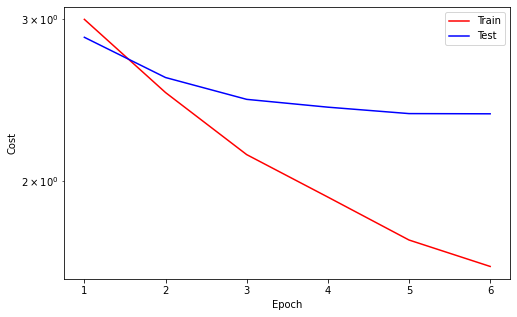

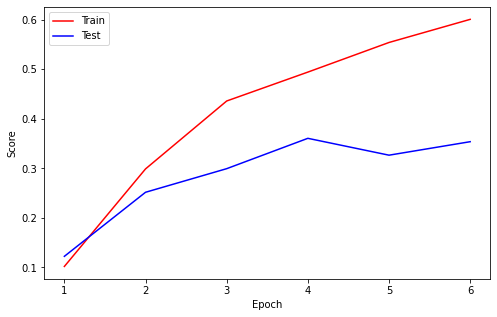

In [222]:
while True:
  train_cost, train_score = loop_fn('train', train_set, trainloader, model, criterion, optimizer, device)
  with torch.no_grad():
    test_cost, test_score = loop_fn('val', val_set, valloader, model, criterion, optimizer, device)

  # Logging
  callback.log(train_cost, test_cost, train_score, test_score)

  # Checkpoint
  callback.save_checkpoint()

  # Runtime Plotting
  callback.cost_runtime_plotting()
  callback.score_runtime_plotting()

  # Early Stopping
  if callback.early_stopping(model, monitor='test_score'):
    callback.plot_cost()
    callback.plot_score()
    break

In [223]:
model.unfreeze()
optimizer = optim.AdamW(model.parameters(), lr=1e-5)

callback.reset_early_stop()
callback.early_stop_patience = 6



Epoch     7
Train_cost  = 1.7358 | Test_cost  = 2.3909 | Train_score = 0.5671 | Test_score = 0.3673 |




Epoch     8
Train_cost  = 1.7127 | Test_cost  = 2.3790 | Train_score = 0.5787 | Test_score = 0.3537 |
==> EarlyStop patience =  1 | Best test_score: 0.3673




Epoch     9
Train_cost  = 1.6473 | Test_cost  = 2.3628 | Train_score = 0.5671 | Test_score = 0.3605 |
==> EarlyStop patience =  2 | Best test_score: 0.3673




Epoch    10
Train_cost  = 1.5864 | Test_cost  = 2.3548 | Train_score = 0.6079 | Test_score = 0.3605 |
==> EarlyStop patience =  3 | Best test_score: 0.3673




Epoch    11
Train_cost  = 1.5444 | Test_cost  = 2.3433 | Train_score = 0.6356 | Test_score = 0.3605 |
==> EarlyStop patience =  4 | Best test_score: 0.3673




Epoch    12
Train_cost  = 1.5273 | Test_cost  = 2.3370 | Train_score = 0.6429 | Test_score = 0.3605 |
==> EarlyStop patience =  5 | Best test_score: 0.3673




Epoch    13
Train_cost  = 1.4894 | Test_cost  = 2.3250 | Train_score = 0.6560 | Test_score = 0.3673 |
==> EarlyStop patience =  6 | Best test_score: 0.3673
==> Execute Early Stopping at epoch: 13 | Best test_score: 0.3673
==> Best model is saved at model


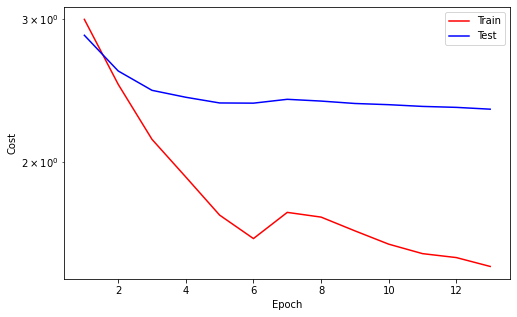

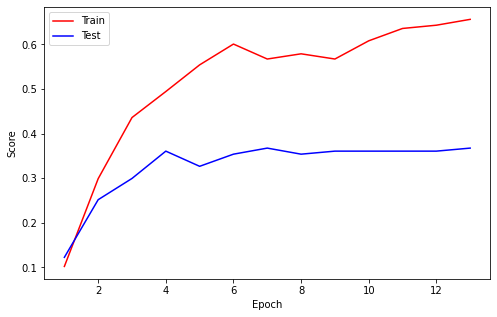

In [224]:
while True:
  train_cost, train_score = loop_fn('train', train_set, trainloader, model, criterion, optimizer, device)
  with torch.no_grad():
    test_cost, test_score = loop_fn('val', val_set, valloader, model, criterion, optimizer, device)

  # Logging
  callback.log(train_cost, test_cost, train_score, test_score)

  # Checkpoint
  callback.save_checkpoint()

  # Runtime Plotting
  callback.cost_runtime_plotting()
  callback.score_runtime_plotting()

  # Early Stopping
  if callback.early_stopping(model, monitor='test_score'):
    callback.plot_cost()
    callback.plot_score()
    break

In [ ]:
for feature, target in valloader:
  feature, target = feature.to(device), target.to(device)
  with torch.no_grad():
    model.eval()
    output = model(feature)
    preds = output.argmax(1)

fig, axes = plt.subplots(6, 6, figsize=(24, 24))
for img, label, pred, ax in zip(feature, target, preds, axes.flatten()):
  ax.imshow(img.permute(1,2,0).cpu())
  font = {"color":'r'} if label != pred else {"color": 'g'}
  label, pred = label2cat[label.item()], label2cat[pred.item()]
  ax.set_title(f"Label: {label}\nPred: {pred}", fontdict=font);
  ax.axis("off");

In [226]:
accuracy = []
for feature, target in testloader:
  feature, target = feature.to(device), target.to(device)
  with torch.no_grad():
    model.eval()
    output = model(feature)
    preds = output.argmax(1)
    if(target == preds):
      acc = 1
    else: acc = 0
    accuracy.append(acc)
accuracy = np.array(accuracy)
accuracy.mean()

0.35135135135135137